In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import numpy as np
import tensorflow as tf
import os.path as osp
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.io import loadmat, savemat

In [3]:
from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.fundamentals.inspect import count_trainable_parameters
from tflearn import is_training

In [4]:
from general_tools.notebook.tf import reset_tf_graph
from geo_tool import Point_Cloud, Mesh
from helper import sub_collection_indices, sub_collection_pose_labels,\
load_pclouds_of_shapes, load_gt_latent_params, load_meshes, make_data, prepare_train_test_val

import helper

from geo_tool.solids.plotting import plot_mesh_via_matplotlib as plot_mesh

In [5]:
def load_consistent_bases(sync_bases_file, n_cons, n_shapes, debug=False):
    synced_bases = loadmat(synced_bases_file)
    synced_bases = synced_bases['sync_bases']
    synced_bases = synced_bases[:, :n_cons]
    
    if debug:
        temp = []
        n_evecs  = int(synced_bases.shape[0]/n_shapes)
        for i in range(0, synced_bases.shape[0], n_evecs):
            temp.append(synced_bases[i:i+n_evecs])
        temp = np.array(temp)
        assert(np.all(synced_bases.reshape((n_shapes, -1, n_cons)) == temp))
    
    return synced_bases.reshape((n_shapes, -1, n_cons))

def pc_net(n_pc_points, do_regression, n_classes, n_filters, n_neurons):    
    with tf.variable_scope('pc_based_net') as scope:
        feed_pl = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
        layer = encoder_with_convs_and_symmetry_new(feed_pl, n_filters=n_filters, b_norm=False)
        n_neurons = n_neurons + [n_classes]
        net_out = decoder_with_fc_only(layer, n_neurons, b_norm=False)
        if do_regression:
            net_out = tf.nn.relu(net_out)
    return feed_pl, net_out

def pc_versions(ver):
    if ver == 'v1':
        n_filters = [32, 64, 64]
        n_neurons = [64]                
    elif ver == 'v2':
        n_filters = [64, 128, 128]
        n_neurons = [64]
    elif ver == 'v3' :
        n_filters = [64, 128, 128]
        n_neurons = [64, 128]    
    else:
        assert(False)
    return n_filters, n_neurons

def produce_diffs(synced_bases_file, n_cons, n_shapes):
    diff_shape = (n_cons, n_cons)
    c_bases = load_consistent_bases(synced_bases_file, n_cons, n_shapes)
    in_diffs = np.zeros(shape=((n_shapes,) + diff_shape))
    for i in xrange(n_shapes):
        in_diffs[i] = c_bases[i].T.dot(c_bases[i])
    return in_diffs

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
total_shapes = helper.total_shapes
n_pose_classes = helper.n_pose_classes

In [8]:
sub_member_per_class = 50
n_shapes = sub_member_per_class * n_pose_classes
seed = 42
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)

n_pc_points = 1024

do_pose_clf = False
do_unsup_clf = False
do_regression = True
n_classes = 12
assert (do_regression + do_unsup_clf + do_pose_clf  == 1)

normalize_pcs = False
mean_norm_diffs = True

In [9]:
top_mesh_dir = '/orions4-zfs/projects/optas/DATA/Meshes/SCAPE_8_poses_2/'
gt_param_f = osp.join(top_mesh_dir, 'gt_shape_params.mat')
synced_bases_file = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses_2/50_extract_0_knn_50_fmapd.mat'

In [10]:
gt_latent_params = load_gt_latent_params(gt_param_f, sub_member_per_class)
in_pcs = load_pclouds_of_shapes(top_mesh_dir, sub_member_per_class, n_pc_points, normalize=normalize_pcs)
pose_labels = sub_collection_pose_labels(sub_member_per_class)

In [11]:
if do_pose_clf:
    n_classes = n_pose_classes
    in_labels = pose_labels
    n_classes = 8
elif do_unsup_clf:    
    unsup_clf = KMeans(n_clusters=n_classes, random_state=seed)
    in_labels = unsup_clf.fit_predict(gt_latent_params)
    plt.hist(in_labels, bins=np.arange(n_classes + 1))
elif do_regression:
    in_labels = gt_latent_params

if do_pose_clf or do_unsup_clf:
    splits = prepare_train_test_val(n_shapes, in_labels, train_per, test_per, seed=seed,
                                    stratify=True)
    np.unique(in_labels, return_counts=True)
else:
    splits = prepare_train_test_val(n_shapes, in_labels, train_per, test_per, seed=seed)

/afs/cs.stanford.edu/u/optas/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [12]:
def neurons_on_first_layer(n_cons):
    if n_cons == 5:
        f_layer = 369
    elif n_cons == 10:
        f_layer = 185
    elif n_cons == 20:
        f_layer = 62
    elif n_cons == 30:
        f_layer = 29
    elif n_cons == 40:
        f_layer = 17
    elif n_cons == 50:
        f_layer = 11
    return f_layer

In [28]:
use_pc = False
arch = 'mlp'
n_cons = 30
f_layer = neurons_on_first_layer(n_cons)
    
if use_pc:
    feeds = in_pcs
else:
    in_diffs = produce_diffs(synced_bases_file, n_cons, n_shapes)
    feeds = in_diffs

in_data = make_data(splits, feeds, in_labels)

train_data = in_data['train']
val_data = in_data['val']
test_data = in_data['test']


if not use_pc and mean_norm_diffs:
    diff_mu = np.mean(train_data.feed, axis=0)
    train_data.feed -= diff_mu
    test_data.feed -= diff_mu
    val_data.feed -= diff_mu

['feed', 'labels', 'ids']
['feed', 'labels', 'ids']
['feed', 'labels', 'ids']


In [173]:
reset_tf_graph()

if do_regression:            
    labels_pl = tf.placeholder(tf.float32, shape=[None, n_classes])
    last_nn = 'relu'
else:
    labels_pl = tf.placeholder(tf.int64, shape=[None])
    last_nn = 'linear'

if use_pc:    
    n_filters, n_neurons = pc_versions('v2')
    feed_pl, net_out = pc_net(n_pc_points, do_regression, n_classes,\
                              n_filters=n_filters, n_neurons=n_neurons)
else:
    in_shape = in_data['train'].feed[0].shape
    with tf.variable_scope('diff_based_net') as scope:
        feed_pl = tf.placeholder(tf.float32, shape = (None, ) + in_shape)        
        if arch == 'mlp':
            layer = fully_connected(feed_pl, f_layer, activation='relu', weights_init='xavier')
            layer = fully_connected(layer, 50, activation='relu', weights_init='xavier')
            layer = fully_connected(layer, 100, activation='relu', weights_init='xavier')
        elif arch == 'conv':
            pass
#             layer = tf.expand_dims(feed_pl, -1)
#             print layer
#             layer = conv_2d(layer, nb_filter=64, filter_size=6, strides=3, activation='relu')
#             print layer
#             layer = conv_2d(layer, nb_filter=64, filter_size=2, strides=2, activation='relu')
#             print layer        
        net_out = fully_connected(layer, n_classes, activation=last_nn, weights_init='xavier')
n_tp = count_trainable_parameters()
print n_tp
assert (n_tp <= 0.01 * 34124 + 34124)
assert (n_tp >= 34124 - 0.01 * 34124)

34423


In [174]:
if do_regression:
    loss = tf.losses.mean_squared_error(labels_pl, net_out)
else:
    prediction = tf.argmax(net_out, axis=1)
    target_ = labels_pl
    correct_pred = tf.equal(prediction, target_)
    avg_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    one_hot_labels = tf.one_hot(labels_pl, depth=n_classes)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=net_out, labels=one_hot_labels)
    loss = tf.reduce_mean(cross_entropy)

if use_pc:
    learning_rate = 0.005
    batch_size = 50
    n_epochs = 500
else:
    learning_rate = 0.007
    batch_size = 50
    n_epochs = 500

opt = tf.train.AdamOptimizer(learning_rate)
opt_step = opt.minimize(loss)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [175]:
train_losses = []
val_losses = []
test_losses = []
batches_for_epoch = train_data.n_examples / batch_size
train_res = defaultdict(list)

In [178]:
verbose = False
for epoch in range(n_epochs):
    is_training(True, session=sess)
    for _ in range(batches_for_epoch):
        batch_d, batch_l, _ = train_data.next_batch(batch_size)
        feed_dict = {feed_pl:batch_d, labels_pl:batch_l}        
        sess.run([opt_step], feed_dict=feed_dict)                
    is_training(False, session=sess)
    if verbose:
        print epoch,
    
    for s in ['train', 'test', 'val']:
        feed_dict = {feed_pl:in_data[s].feed, labels_pl:in_data[s].labels}
        if do_regression:
            r = sess.run([loss], feed_dict=feed_dict)
        else:
            r = sess.run([avg_accuracy], feed_dict=feed_dict)
        train_res[s].append(r)
        if verbose:
            print r,
    if verbose:
        print

In [179]:
if do_regression:
    seek = np.min(train_res['val'])
else:
    seek = np.max(train_res['val'])
    
val_maximizers = np.where(train_res['val'] == seek)[0]
val_maximizer = val_maximizers[0]
val_best = np.array(train_res['test'])[val_maximizer]

print len(val_maximizers)
print val_maximizer
print val_best - np.array(train_res['train'])[val_maximizer]
print val_best

1
347
[ 0.01828104]
[ 0.03207297]


In [ ]:
# PLOT net stats.
plt.plot(train_res['train'])
plt.plot(train_res['test'])
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

if use_pc:
    title_tag = 'Raw input'
else:
    title_tag = 'Diff-map input (%s)' % (arch,)

plt.title('%s Net-stats for body-variation.'% (title_tag, ))
# plt.text(100, 0.3, 'best by val:%.4f' % (val_best,), fontsize=12);

In [58]:
from general_tools.clustering.plt import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
s = 'test'
l = in_data[s].labels

feed_dict = {feed_pl:in_data[s].feed, labels_pl:l}
p = sess.run([prediction], feed_dict=feed_dict)[0]

conf_m = confusion_matrix(l, p)

Confusion matrix, without normalization
[[2 0 0 0 1 0 0 1 1 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 1 0 0 0 0 0 0 0 0]
 [1 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 1 0 5 0 0 0 0 0 0]
 [0 0 1 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 1 0 0 5 0 0 0 0]
 [0 0 0 0 1 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0]
 [1 0 0 0 0 0 0 0 0 0 3 1]
 [0 0 0 0 0 0 0 0 0 1 0 3]]


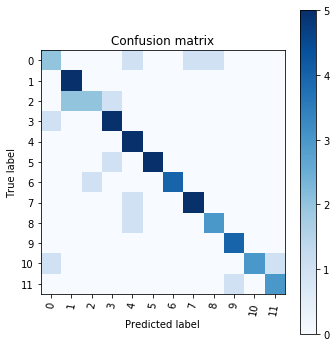

In [62]:
import inspect
inspect.getargspec(plot_confusion_matrix)
plot_confusion_matrix(conf_m, np.unique(in_labels))

In [65]:
in_class_p = 0.01
out_class_p = 0.01
p_matrix = np.ones(shape = (n_classes, n_classes)) * out_class_p
np.fill_diagonal(p_matrix, in_class_p)
adj = SBM_from_class_labels(sorted(in_labels), p_matrix)

500

In [48]:
import random
import numpy as np

def SBM_from_class_labels(vertex_labels, p_matrix):
    n_vertices = len(vertex_labels)
    adjacency = np.zeros(shape=(n_vertices, n_vertices), dtype=np.bool)
    for row, _row in enumerate(adjacency):
        for col, _col in enumerate(adjacency[row]):
            community_a = vertex_labels[row]
            community_b = vertex_labels[col]
            
            p = random.random()
            val = p_matrix[community_a][community_b]

            if p <= val:
                adjacency[row][col] = 1
                adjacency[col][row] = 1
    return adjacency

In [67]:
# feed_dict = {diffs_pl:test_data.diff_maps, labels_pl:test_data.labels}
# pred = sess.run(prediction, feed_dict=feed_dict)
# missed = np.where(test_data.labels != pred)
# pred[missed]
# test_data.labels[missed]
# test_data.ids[missed]

In [207]:
grid_scaler = np.arange(np.prod(diff_dims)).reshape(diff_dims)
loc_scaled_diffs = []
for d in in_diffs:
    loc_scaled_diffs.append(d + grid_scaler)

In [ ]:
# d = in_diffs[0]
# # plt.imshow(d)
# # d = np.hstack((d, np.zeros(50).reshape(-1, 1)))
# # print d.shape
# # # coeffs = pywt.dwt2(d, 'haar')
# # # print coeffs[0].shape
# # cc = (d[0:25,0:13], (d[0:25, 13:], d[25:, 0:13], d[25:,13:]))
# # lala = pywt.idwt2(cc, 'haar')
# # # plt.imshow(lala)
# # plt.imshow(lala)
# # plt.imshow(np.bmat([coeffs[0], coeffs[1][0]],[coeffs[1][1], coeffs[1][2]]))
# # plt.imshow(in_diffs[-1])
# # len(coeffs)
# # coeffs[1][2].shape

# import pywt

# haar_diffs = []
# for d in in_diffs:
# #     coeffs = pywt.dwt2(d, 'haar')
# #     haar_diffs.append(coeffs[0])

#     dd = np.hstack((d, np.zeros(50).reshape(-1, 1)))
#     cc = (dd[0:25,0:13], (dd[0:25, 13:], dd[25:, 0:13], dd[25:,13:]))
#     haar_diffs.append(pywt.idwt2(cc, 'haar'))

# #     coeffs = [d, (d, d, d)]
# #     haar_diffs.append(pywt.idwt2(coeffs, 'haar'))


# haar_diffs = np.array(haar_diffs)

In [ ]:


# for epoch in range(n_epochs):
#     for _ in range(batches_for_epoch):        
#         batch_d, batch_l, batch_dd = train_data.next_batch(batch_size)
#         feed_dict = {feed_pl_1:batch_d, labels_pl:batch_l, feed_pl_2:batch_dd}
#         sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)
    
#     print epoch,
#     for s in ['train', 'test', 'val']:
#         feed_dict = {feed_pl_1:in_data[s].feed, labels_pl:in_data[s].labels, feed_pl_2:in_data[s].ids}
#         r = sess.run([avg_accuracy], feed_dict=feed_dict)        
#         train_res[s].append(r)
#         print r,
#     print


# from tf_lab.data_sets.numpy_dataset import NumpyDataset
# def make_data_mixed(in_data, in_pc, class_labels, in_diff):
#     res = dict()
#     for s in ['train', 'test', 'val']:
#         idx = in_data[s].copy()        
#         res[s] = NumpyDataset([in_pc[idx], class_labels[idx], in_diff[idx]], ['feed', 'labels', 'ids'])
#     return res

# in_data = make_data_mixed(splits, in_pcs, in_labels, in_diffs)

In [ ]:
# is_directed = False
# n_shapes
# from geo_tool.utils.graph_generators import gnm_random_graph
# from geo_tool import Graph

# g = gnm_random_graph(n_shapes, n_shapes*4, directed=is_directed)
# print Graph.connected_components(g)[0]
# gg = Graph(g, is_directed)


# # splits['train']

# in_class_p = 0.01
# out_class_p = 0.05
# p_matrix = np.ones(shape = (n_classes, n_classes)) * out_class_p
# np.fill_diagonal(p_matrix, in_class_p)


# adj = SBM_from_class_labels(in_labels, p_matrix)

# for s in ['test', 'val']:
#     for idx in splits[s]:
#         adj[idx,:] = 0
#         adj[:,idx] = 0
        
# plt.imshow(g.toarray())
# plt.imshow(adj)

# mixed = np.array(g.toarray() + adj, dtype=bool)
# savemat('50_mixed_net.mat', {'W': mixed} )

In [ ]:
#     labels_pl = tf.placeholder(tf.int64, shape=[None])
#     diff_dims = (60, 30)
#     feed_pl_1 = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
#     feed_pl_2 = tf.placeholder(tf.float32, shape = (None, ) + diff_dims)
    
#     layer_pc = encoder_with_convs_and_symmetry_new(feed_pl_1, n_filters=[64, 128], b_norm=False)
    
    
#     layer = conv_2d(tf.expand_dims(feed_pl_2, -1), nb_filter=4, filter_size=4, activation='relu')
#     layer = max_pool_2d(layer, kernel_size=2)
#     layer = conv_2d(layer, nb_filter=4, filter_size=3, activation='relu')
#     layer = max_pool_2d(layer, kernel_size=2)
#     layer = fully_connected(layer, 6, activation='relu', weights_init='xavier')    
#     layer_diff = fully_connected(layer, 64, activation='relu', weights_init='xavier')
#     layer = tf.concat([layer_pc, layer_diff], axis=1)    
#     layer = fully_connected(layer, 32, activation='relu', weights_init='xavier')
#     logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
    

In [164]:
def add_location_info_on_diffs(in_diffs, scaler=1.0):
    diff_dims = in_diffs.shape[1:]
    row_pos = np.repeat(np.arange(diff_dims[0]), diff_dims[1]).reshape(diff_dims)
    col_pos = np.repeat(np.arange(diff_dims[1]), diff_dims[0]).reshape(diff_dims[1], diff_dims[0]).T
    row_pos = row_pos.astype(np.float32)
    col_pos = col_pos.astype(np.float32)
    row_pos *= scaler
    col_pos *= scaler

    diffs_with_pos = np.zeros(shape=in_diffs.shape + (3,))
    for i, d in enumerate(in_diffs):
        diffs_with_pos[i, :, :, 0] = d
        diffs_with_pos[i, :, :, 1] = row_pos
        diffs_with_pos[i, :, :, 2] = col_pos
    return diffs_with_pos


In [ ]:
# Latest from Ruqi - see email.
# import hdf5storage
# synced_bases_file = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/latent_basis_400_shapes_60_eigs.mat'
# synced_bases_file = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/complete_400_shapes.mat'
# in_data = loadmat(synced_bases_file)
# in_data = hdf5storage.loadmat(synced_bases_file)
# print in_data.keys()
# in_d = in_data['Cbases_ordered']
# in_d = in_data['Cbases']
# in_d = in_data['CB2_ordered']
# in_d = in_data['CB2']
# n_shapes = len(in_d)
# c_dim = in_d[1][0].shape
# temp = np.zeros(shape=(n_shapes, ) + c_dim )
# for i in xrange(n_shapes):
#     temp[i] = in_d[i][0]
# c_bases = temp